In [18]:
%load_ext autoreload
%autoreload 2
from cs285.envs.pendulum.pendulum_env import PendulumEnv
from cs285.envs.dt_sampler import ConstantSampler
from cs285.infrastructure.replay_buffer import ReplayBufferTrajectories
from cs285.infrastructure.utils import sample_n_trajectories, RandomPolicy
from cs285.agents.ode_agent import ODEAgent
from cs285.agents.ode_agent_true_dynamics import ODEAgent_True_Dynamics
from typing import Callable, Optional, Tuple, Sequence
import numpy as np
import torch.nn as nn
import torch
import gym
from cs285.infrastructure import pytorch_util as ptu
from torchdiffeq import odeint
from tqdm import trange
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
from diffrax import diffeqsolve, Dopri5
import optax
import matplotlib.pyplot as plt
import wandb
import pprint


import pprint


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
key = jax.random.PRNGKey(0)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
device = "cuda" if torch.cuda.is_available() else "cpu"
ptu.init_gpu(use_gpu=True if device=="cuda" else False)

gpu
Using GPU id 0


In [20]:
dt_sampler = ConstantSampler(dt=0.05)
env = PendulumEnv(
    dt_sampler=dt_sampler
)

In [21]:
def test_true_dynamics_agent(agent, ntraj):
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
    rewards = [t["episode_statistics"]["r"] for t in trajs]
    # plt.hist(returns, bins=20)
    mean, std, min, max = np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)
    print("mean", mean)
    print("std", std)
    print("min", min)
    print("max", max)
    stats = {
        "mean": mean,
        "std": std,
        "min": min,
        "max": max
    }
    return rewards, stats

100%|██████████| 10/10 [06:28<00:00, 38.85s/it]

mean -1207.9994
std 602.4616
min -1541.8062
max -3.2999287


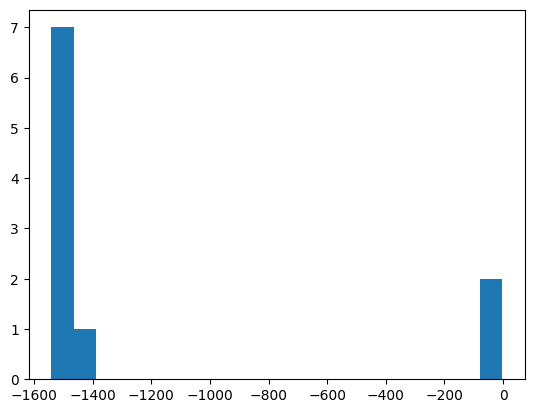

In [24]:
agent = ODEAgent_True_Dynamics(
    env=env,
    mpc_horizon_steps=100,
    mpc_timestep=0.005,
    mpc_strategy="cem",
    mpc_discount=0.9,
    mpc_num_action_sequences=1000,
    cem_num_iters=4,
    cem_num_elites=5,
    cem_alpha=1,
)
rewards, stats = test_true_dynamics_agent(agent, ntraj=10)


In [22]:
wandb.init()

/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [23]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'mean',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'mpc_horizon_steps': {
        'values': [1, 2, 5, 10, 20, 50, 100, 200]
        },
    'mpc_timestep': {
        'value': 0.05
        },
    'mpc_discount': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]
        },
    "mpc_num_action_sequences": {
        'values': [100, 200, 500, 1000, 2000, 5000]
        },
    'mpc_strategy': {
        'values': ["random", "cem"]
        },
    'cem_num_iters': {
        'values': [2, 4, 8, 16],
        },
    'cem_num_elites': {
        'values': [1, 2, 4, 8, 16, 32, 64],
        },
    'cem_alpha': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5],
        },
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)


{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'mean'},
 'parameters': {'cem_alpha': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'cem_num_elites': {'values': [1, 2, 4, 8, 16, 32, 64]},
                'cem_num_iters': {'values': [2, 4, 8, 16]},
                'mpc_discount': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'mpc_horizon_steps': {'values': [1,
                                                 2,
                                                 5,
                                                 10,
                                                 20,
                                                 50,
                                                 100,
                                                 200]},
                'mpc_num_action_sequences': {'values': [100,
                                                        200,
                                                        500,
                                     

In [24]:
sweep_id = wandb.sweep(sweep_config, project="cs285_proj_get_action_true_dynamics")

Create sweep with ID: a84q0755
Sweep URL: https://wandb.ai/zekai-wang/cs285_proj_get_action_true_dynamics/sweeps/a84q0755


In [25]:
def evaluate(config=None):
    with wandb.init(config=config):
        config = wandb.config
        agent = ODEAgent_True_Dynamics(
            env=env,
            mpc_horizon_steps=config.mpc_horizon_steps,
            mpc_timestep=config.mpc_timestep,
            mpc_strategy=config.mpc_strategy,
            mpc_discount=config.mpc_discount,
            mpc_num_action_sequences=config.mpc_num_action_sequences,
            cem_num_iters=config.cem_num_iters,
            cem_num_elites=config.cem_num_elites,
            cem_alpha=config.cem_alpha,
        )
        rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
        wandb.log({"rewards": rewards,
                   "stats": stats,
                   "min": stats["min"],
                   "max": stats["max"],
                   "mean": stats["mean"],
                   "std": stats["std"],})


In [26]:
wandb.agent(sweep_id, evaluate, count=200)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 917, in run
    self.run()
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 268, in check_network_status
    self._loop_check_status(
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python

100%|██████████| 10/10 [03:49<00:00, 22.99s/it]


mean -722.0479
std 282.66434
min -1008.9755
max -129.62756


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-129.62756
mean,-722.04791
min,-1008.97552
std,282.66434


wandb: Agent Starting Run: cx1nlers with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


100%|██████████| 10/10 [01:45<00:00, 10.51s/it]


mean -470.13452
std 547.89136
min -1523.1104
max -0.16351229


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-0.16351
mean,-470.13452
min,-1523.11035
std,547.89136


wandb: Agent Starting Run: 56sa5n0j with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


mean -1199.508
std 425.01773
min -1583.6694
max -0.62472725


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-0.62473
mean,-1199.50806
min,-1583.66943
std,425.01773


wandb: Agent Starting Run: 8wiqshqg with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_163285/2625986174.py", line 15, in evaluate
    rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
  File "/tmp/ipykernel_163285/1321374163.py", line 2, in test_true_dynamics_agent
    trajs, _ = sample_n_trajectories(env, agent, ntraj=ntraj, max_length=200, key=key)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 123, in sample_n_trajectories
    traj = sample_trajectory(env, policy, max_length, sample_key, render)
  File "/home/zekai/repos/cs285_proj/cs285/infrastructure/utils.py", line 49, in sample_trajectory
    ac = policy.get_action(ob, key=ac_key)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_module.py", line 1011, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/equinox/_jit.py", line 206, in __call__
    re

wandb: ERROR Run 8wiqshqg errored: AssertionError('u.shape=(), observations.shape=(1, 3)')
wandb: Agent Starting Run: iaqtuzlu with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [03:41<00:00, 22.14s/it]


mean -650.73206
std 345.2816
min -1076.7504
max -127.02426


max,▁
mean,▁
min,▁
std,▁
max,-127.02426
mean,-650.73206
min,-1076.75037
std,345.28159


wandb: Agent Starting Run: 5f0qry80 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


mean -185.77225
std 125.30916
min -375.0008
max -0.8354941


max,▁
mean,▁
min,▁
std,▁
max,-0.83549
mean,-185.77225
min,-375.00079
std,125.30916


wandb: Agent Starting Run: qohpdand with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


mean -176.6659
std 83.98125
min -378.369
max -121.10578


max,▁
mean,▁
min,▁
std,▁
max,-121.10578
mean,-176.66589
min,-378.36899
std,83.98125


wandb: Agent Starting Run: cjkgu6bo with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
wandb: 	mpc_timestep: 0.05
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


 30%|███       | 3/10 [00:19<00:45,  6.45s/it]